In [18]:
import numpy as np
from scipy import linalg
from scipy.special import binom
import matplotlib.pyplot as plt
import itertools as it
import copy
import stomp_functions as stf
import time
import os
import re
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

In [19]:
def create_H(N, g, j):
    z_ops, x_ops = stf.construct_op_lists(N)
    
    # Construct the Hamiltonian
    # Loop over sites to construct parts of H
    H_qis = 0
    for n in range(N-1):
        H_qis += -j * z_ops[n] @ z_ops[n+1]
        for m in range(N):
            H_qis += -j * g * x_ops[m]

    return H_qis

In [20]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [21]:
# Define Hamiltonian parameters
N = 4
g = 2
j = 1

In [22]:
# Create the Hamiltonian
H = create_H(N, g, j)

# Get energy eigenvalues
E = linalg.eigvalsh(H.to_matrix())
print(E)

[-24.12507182 -13.70595333 -12.65021759 -11.41911848 -10.47485423
  -2.23109911  -1.          -0.05573574   0.05573574   1.
   2.23109911  10.47485423  11.41911848  12.65021759  13.70595333
  24.12507182]


In [23]:
# Define filenames for loading
ovlp_file = "ovlp_aersim_N=4_t=1_numsteps=200_g=2.npz"
H_ovlp_file = "H_ovlp_aersim_N=4_t=1_numsteps=200_g=2.npz"

In [24]:
# Load in data
ovlp_data = np.load(ovlp_file, allow_pickle=True)
H_ovlp_data = np.load(H_ovlp_file, allow_pickle=True)

In [25]:
print(ovlp_data.files)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [26]:
# Get beta value and numsteps from filename
τ = float(re.search(r't=\d', ovlp_file).group(0)[2:])
num_steps = int(re.search(r'numsteps=\d+', ovlp_file).group(0)[9:])
τs, dτ = np.linspace(0, τ, num_steps, retstep=True)

Text(0, 0.5, 'Im(Ovlp)')

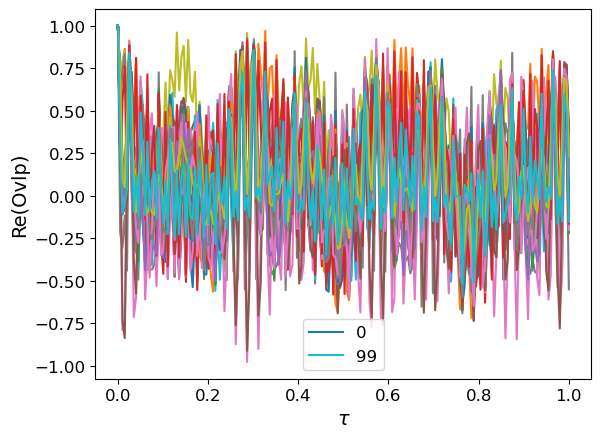

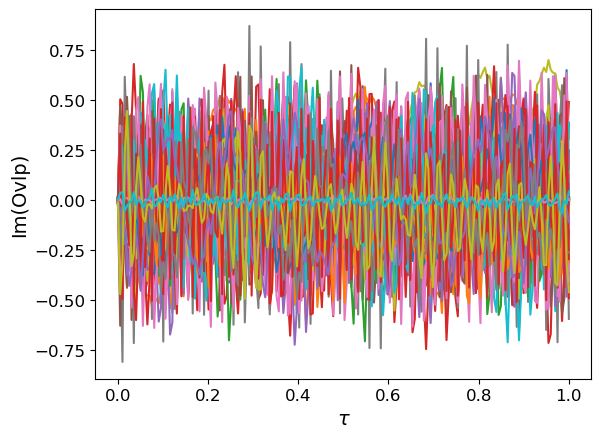

In [27]:
# Just plot all the overlap data
fig = plt.figure(1)
ax = fig.add_subplot(111)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
for key in ovlp_data:
    if key == list(ovlp_data.keys())[0] or key == list(ovlp_data.keys())[-1]:
        ax.plot(τs, ovlp_data[key].real, label=key)
        ax2.plot(τs, ovlp_data[key].imag, label=key)
    else:
        ax.plot(τs, ovlp_data[key].real)
        ax2.plot(τs, ovlp_data[key].imag)
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Re(Ovlp)")
ax.legend()

ax2.set_xlabel("$\\tau$")
ax2.set_ylabel("Im(Ovlp)")

Text(0, 0.5, 'Im($\\langle\\hat{H}\\rangle$)')

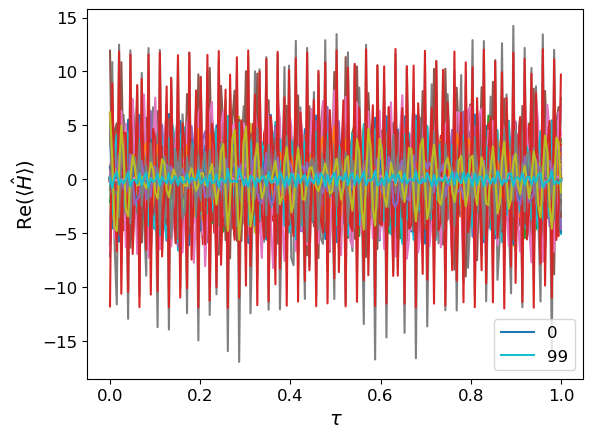

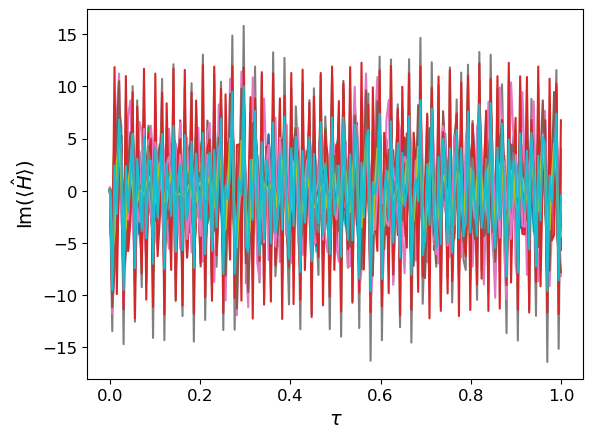

In [28]:
# Just plot all the overlap data
fig = plt.figure(1)
ax = fig.add_subplot(111)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
for key in ovlp_data:
    if key == list(ovlp_data.keys())[0] or key == list(ovlp_data.keys())[-1]:
        ax.plot(τs, H_ovlp_data[key].real, label=key)
        ax2.plot(τs, H_ovlp_data[key].imag, label=key)
    else:
        ax.plot(τs, H_ovlp_data[key].real)
        ax2.plot(τs, H_ovlp_data[key].imag)
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Re($\\langle\\hat{H}\\rangle$)")
ax.legend()

ax2.set_xlabel("$\\tau$")
ax2.set_ylabel("Im($\\langle\\hat{H}\\rangle$)")

In [29]:
# Check convergence to ground and first excited states for each run
calc_E = {}
for λ in E:
    temp_dict = {}
    for i in range(len(ovlp_data.files)):
        z = ovlp_data[str(i)]
        O = H_ovlp_data[str(i)]
        temp_dict[str(i)] = stf.alt_partition_calc(z, O, num_steps, λ, dτ)[1][1:] - λ
    calc_E[λ] = temp_dict

In [30]:
avg_E = {}
for key in calc_E:
    temp = np.zeros(τs[2::2].size, dtype=complex)
    for key2 in calc_E[key]:
        temp += calc_E[key][key2]
    avg_E[key] = temp / len(list(calc_E[key].keys()))

In [31]:
# Try averaging the overlap data first
avg_z = 0
avg_O = 0
for i in range(len(ovlp_data.files)):
    avg_z += ovlp_data[str(i)]
    avg_O += H_ovlp_data[str(i)]
avg_z /= len(ovlp_data.files)
avg_O /= len(H_ovlp_data.files)

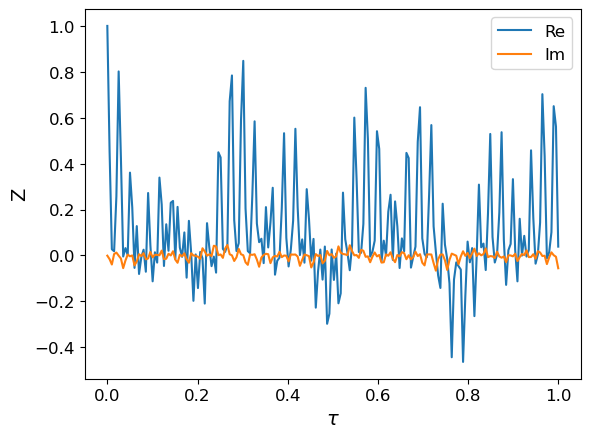

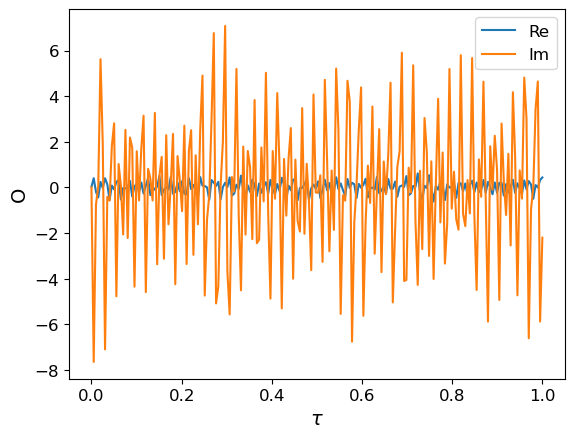

In [32]:
# Just plot all the overlap data
fig = plt.figure(1)
ax = fig.add_subplot(111)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
ax.plot(τs, avg_z.real, label='Re')
ax.plot(τs, avg_z.imag, label='Im')
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Z")
ax.legend()

ax2.plot(τs, avg_O.real, label='Re')
ax2.plot(τs, avg_O.imag, label='Im')
ax2.set_xlabel("$\\tau$")
ax2.set_ylabel("O")
ax2.legend()

In [33]:
mean_E = {}
for λ in E:
    mean_E[λ] = stf.alt_partition_calc(avg_z, avg_O, num_steps, λ, dτ)[1][1:] - λ

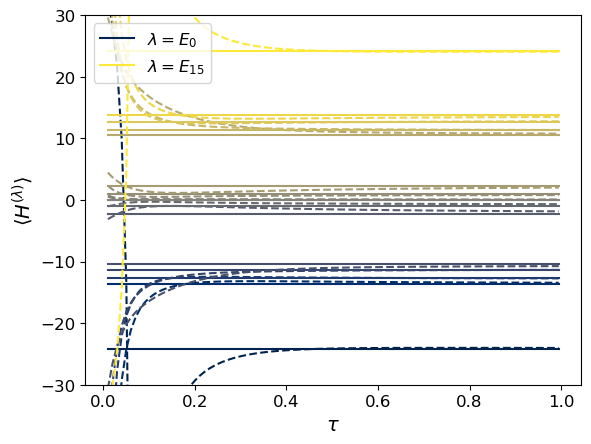

In [46]:
colors = mpl.colormaps['cividis'].resampled(E.size).colors
for i, λ in enumerate(E):
    if i == 0 or i == E.size - 1:
        plt.plot(τs[2::2], mean_E[λ], '--', color=colors[i])
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors[i], label='$\\lambda=E_{'+str(i)+'}$')
    else:
        plt.plot(τs[2::2], mean_E[λ], '--', color=colors[i])
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors[i])
plt.legend()
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle H^{(\\lambda)}\\rangle$")
plt.ylim([-30, 30])
plt.savefig("aersim_result.png", format='png', dpi=300)

/home/jacob/anaconda3/envs/EnergyGaps/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'E')

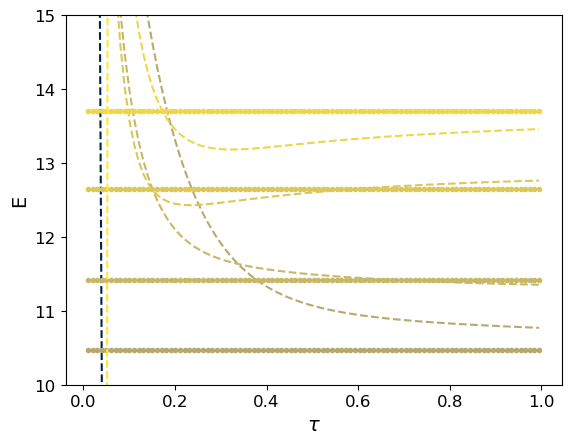

In [38]:
for i, λ in enumerate(E):
    plt.plot(τs[2::2], mean_E[λ], '--', color=colors[i])
    plt.plot(τs[2::2], λ * np.ones(τs[2::2].shape[0]), '.-', color=colors[i])
plt.xlabel("$\\tau$")
plt.ylim([10, 15])
plt.ylabel("E")

Text(0, 0.5, 'E')

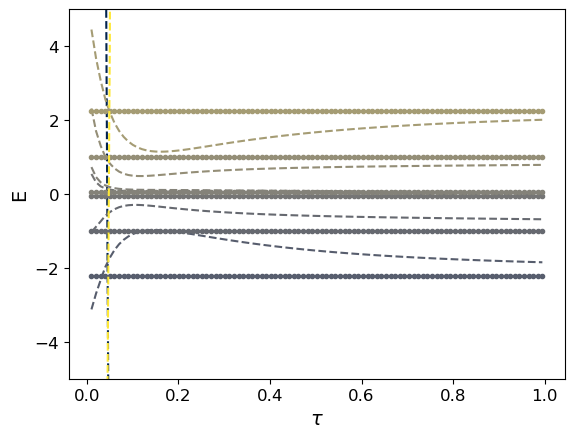

In [39]:
for i, λ in enumerate(E):
    plt.plot(τs[2::2], mean_E[λ], '--', color=colors[i])
    plt.plot(τs[2::2], λ * np.ones(τs[2::2].shape[0]), '.-', color=colors[i])
plt.xlabel("$\\tau$")
plt.ylim([-5, 5])
plt.ylabel("E")

Text(0, 0.5, 'E')

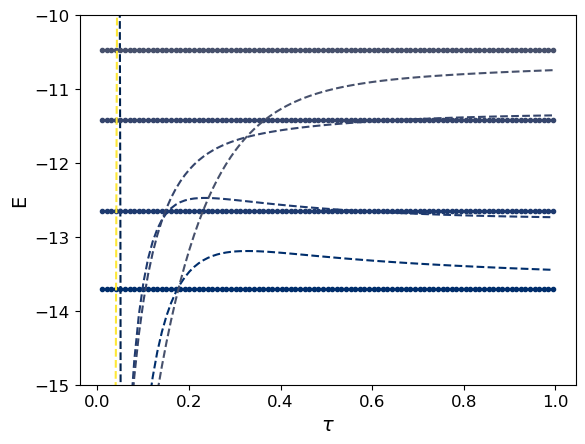

In [40]:
for i, λ in enumerate(E):
    plt.plot(τs[2::2], mean_E[λ], '--', color=colors[i])
    plt.plot(τs[2::2], λ * np.ones(τs[2::2].shape[0]), '.-', color=colors[i])
plt.xlabel("$\\tau$")
plt.ylim([-15, -10])
plt.ylabel("E")

In [41]:
err = {}
for λ in E:
    err[λ] = np.abs(λ - mean_E[λ][-1])

Text(0, 0.5, 'Abs. Err')

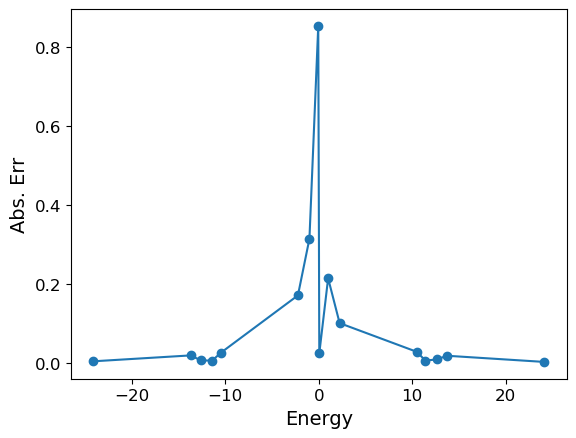

In [43]:
plt.plot(E, np.array(list(err.values())), 'o-')
plt.xlabel("Energy")
plt.ylabel("Abs. Err")